# Interpolate cf dataset fields on a given regular lat lon grid


In [1]:
import xarray as xr
import numpy as np

In [2]:
from math import pi
import numpy as np

def lonlat(np_true_long, np_true_lat, lonp, latp):
    """Map latp and lonp in the rotated pole coordinates to standard lat and lon
       np_true_lat is the true latitude of the north pole of the new coord system
       np_true_long   is the true longitude of the north pole of the new coord system
    """
    # we assume that the transform was first a rotation on the Z and then a rotation on the long=0 circle 
    np_true_long = np_true_long % 360
    if abs(np_true_long) > 90:
        phi = np_true_long - 180
        theta = -(90 - np_true_lat)
    else:
        phi = np_true_long
        theta = 90 - np_true_lat
    # phi is how much we, first, rotated around the Z axis
    # theta is how much we then rotated around the new Y axis
    theta = pi * (theta/180)
    phi = pi * (phi/180)
    latp = pi * latp/180
    lonp = pi * lonp/180
    lat = np.arcsin(np.cos(theta) * np.sin(latp) - np.cos(lonp) * np.sin(theta) * np.cos(latp))
    lon = np.arctan2(np.sin(lonp), np.tan(latp) * np.sin(theta) + np.cos(lonp) * np.cos(theta)) + phi
    return 180 * lon / pi, 180 * lat/pi

def invlonlat(np_true_long, np_true_lat, lon, lat):
    """Map standard lat lon to latp and lonp in the rotated pole coordinates
       np_true_lat is the true latitude of the north pole of the new coord system
       np_true_long   is the true longitude of the north pole of the new coord system
    """
    # we assume that the transform was first a rotation on the Z and then a rotation on the long=0 circle 
    np_true_long = np_true_long % 360
    if abs(np_true_long) > 90:
        phi = np_true_long - 180
        theta = -(90 - np_true_lat)
    else:
        phi = np_true_long
        theta = 90 - np_true_lat
    # phi is how much we, first, rotated around the Z axis
    # theta is how much we then rotated around the new Y axis
    theta = pi * (theta/180)
    phi = pi * (phi/180)
    lat = pi * lat/180
    lon = pi * lon/180
    lon = lon - phi
    theta = -theta
    latp = np.arcsin(np.cos(theta) * np.sin(lat) - np.cos(lon) * np.sin(theta) * np.cos(lat))
    lonp = np.arctan2(np.sin(lon), np.tan(lat) * np.sin(theta) + np.cos(lon) * np.cos(theta))
    return 180 * lonp / pi, 180 * latp/pi

In [3]:
fname = './data/moloch_2018050103.cf'
d = xr.open_dataset(fname)

In [4]:
rotated_pole = d.variables['rotated_pole']
np_lon = rotated_pole.attrs['grid_north_pole_longitude']
np_lat = rotated_pole.attrs['grid_north_pole_latitude']
rlon, rlat = d.variables['rlon'].values - 360, d.variables['rlat'].values

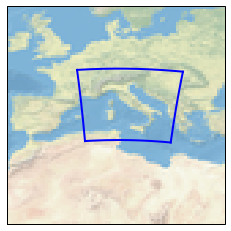

In [5]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.text as text

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent((-10, 30, 20, 60), crs=ccrs.PlateCarree())

left = lonlat(np_lon, np_lat, rlon.min(), rlat)
right = lonlat(np_lon, np_lat, rlon.max(), rlat)
bottom = lonlat(np_lon, np_lat, rlon, rlat.min())
top = lonlat(np_lon, np_lat, rlon, rlat.max())
for side in [bottom, left, top, right]:
    plt.plot(side[0], side[1],
             color='blue', linewidth=2, ## marker='o',
             transform=ccrs.PlateCarree(),
             )
plt.show()

In [6]:
N = 200
slon = np.linspace(7, 12, N)
slat = np.linspace(37, 43, N)

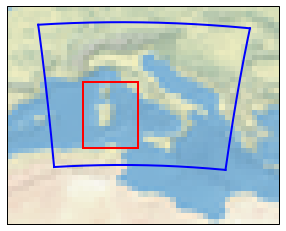

In [7]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent((0, 25, 30, 50), crs=ccrs.PlateCarree())

left = lonlat(np_lon, np_lat, rlon.min(), rlat)
right = lonlat(np_lon, np_lat, rlon.max(), rlat)
bottom = lonlat(np_lon, np_lat, rlon, rlat.min())
top = lonlat(np_lon, np_lat, rlon, rlat.max())
for side in [bottom, left, top, right]:
    plt.plot(side[0], side[1],
             color='blue', linewidth=2, ## marker='o',
             transform=ccrs.PlateCarree(),
             )
plt.plot([slon.min(),] * N, slat, color='red',
         linewidth=2, ## marker='o',
         transform=ccrs.PlateCarree(),
         )
plt.plot([slon.max(),] * N, slat, color='red',
         linewidth=2, ## marker='o',
         transform=ccrs.PlateCarree(),
         )
plt.plot(slon, [slat.min(),] * N, color='red',
         linewidth=2, ## marker='o',
         transform=ccrs.PlateCarree(),
         )
plt.plot(slon, [slat.max(),] * N, color='red',
         linewidth=2, ## marker='o',
         transform=ccrs.PlateCarree(),
         )
plt.show()

In [8]:
from scipy.interpolate import interpn

class interpolator(object):
    def __init__(self, dataset, lonvals, latvals):
        self.ds = dataset
        self.lonvals, self.latvals = lonvals, latvals
        self.ipoints, self.icoords = self._get_nodes_projection(lonvals, latvals)
        
    def _get_nodes_projection_rotated_pole(self, lonvals, latvals):
        """
        Projects in the rotated pole coordinate system defined in self.ds 
        the nodes of the (true lon)x(true lat) regular grid defined by lonvals x latvals.
        
        Returns node_cords, (rlon, rlat)
        where rlon and rlat define the boundaries, in the rotated pole coordinate system, 
        of the regular grid on which self.ds variables are defined FIXME this is not generically true.
        """
        rotated_pole = self.ds.variables['rotated_pole']
        np_lon = rotated_pole.attrs['grid_north_pole_longitude']
        np_lat = rotated_pole.attrs['grid_north_pole_latitude']
        # project nodes to their rotated pole map coordinates
        rslon, rslat = list(map(np.stack, zip(*[invlonlat(np_lon, np_lat, lonvals, l) 
                                                for l in latvals])))
        # for later interpolation purposes, we get the boundaries, 
        # in the rotated pole coordinate system, of the regulat grid that supports the data fields
        # by CF conventions, it is in the variables rlon and rlat
        rlon, rlat = d.variables['rlon'].values, d.variables['rlat'].values
        # confine lon to -180, 180
        rlon = rlon % 360
        rlon = rlon - (rlon > 180)*360
        return np.hstack([rslon.reshape(-1, 1), rslat.reshape(-1, 1)]), (rlon, rlat)
        
    def _get_nodes_projection(self, lonvals, latvals):
        if 'rotated_pole' in self.ds.variables:
            return self._get_nodes_projection_rotated_pole(lonvals, latvals)
        else:
            raise ValueError('Unknown projection')
    
    def interpolate(self, fieldname, selectors):
        ds = self.ds.sel(selectors)
        field = ds.variables[fieldname]
        v = interpn(self.icoords, field.values, self.ipoints)
        return xr.DataArray(v.reshape(len(self.lonvals), len(self.latvals)), 
                            dims=['lon', 'lat'], 
                            coords={'lon': self.lonvals, 'lat': self.latvals})           

In [9]:
interp = interpolator(d, slon, slat)

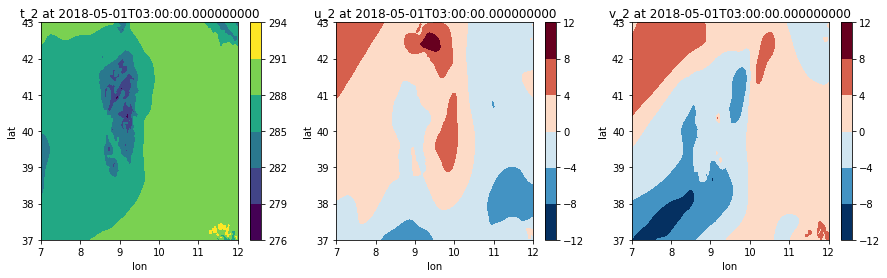

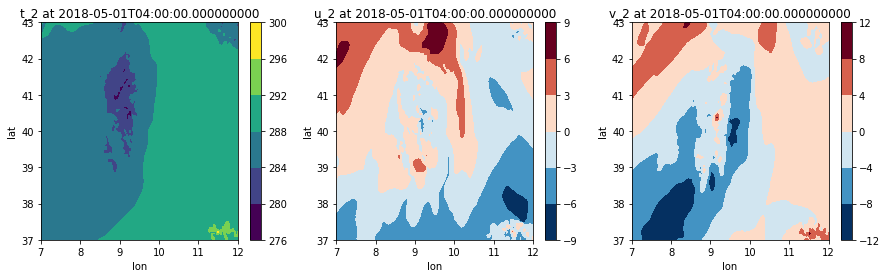

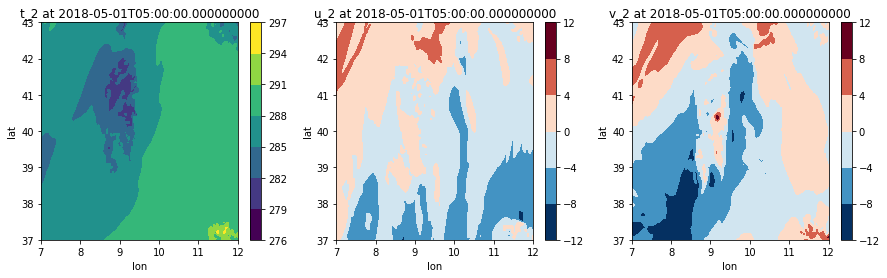

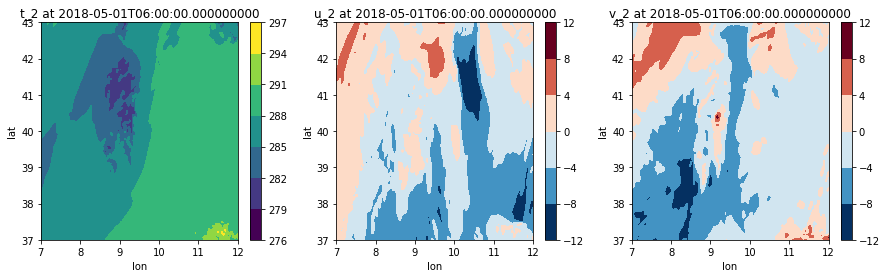

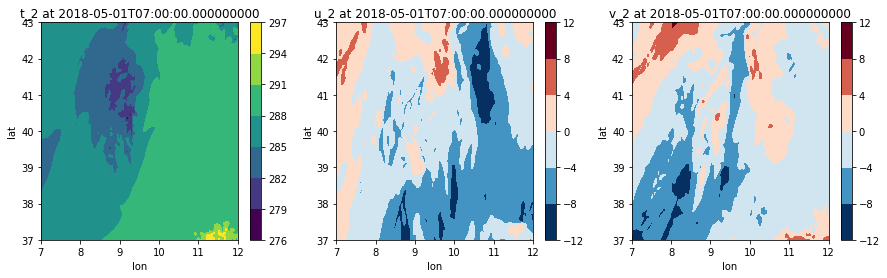

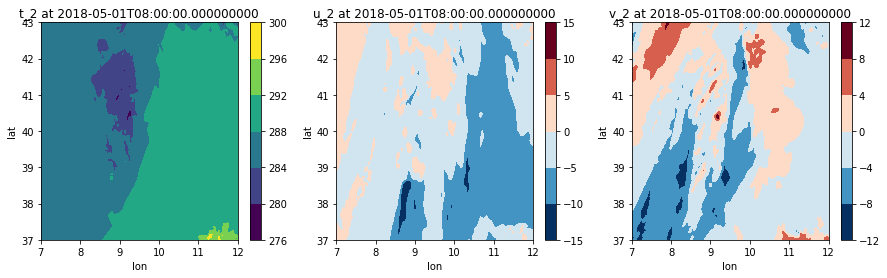

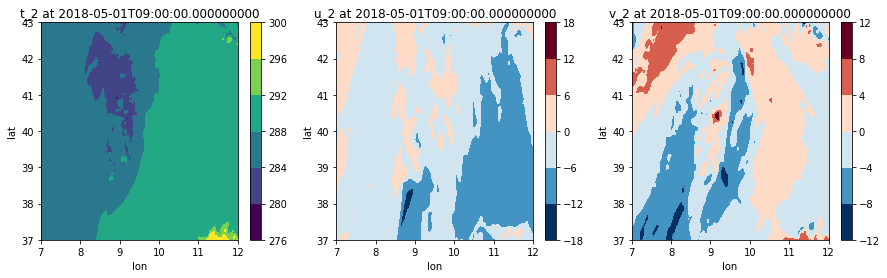

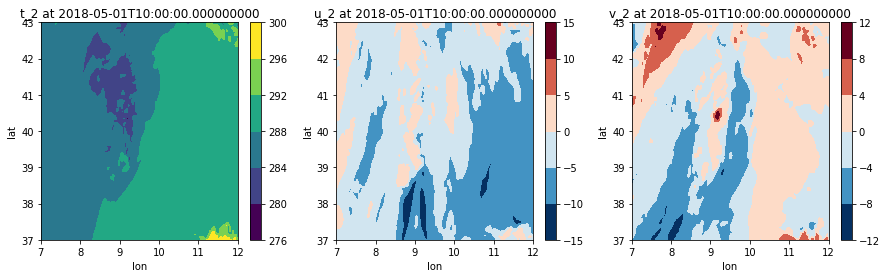

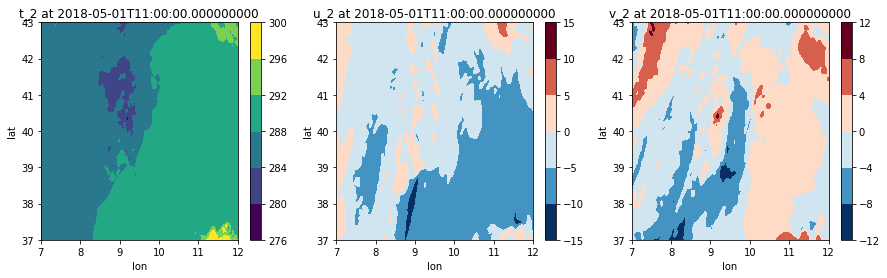

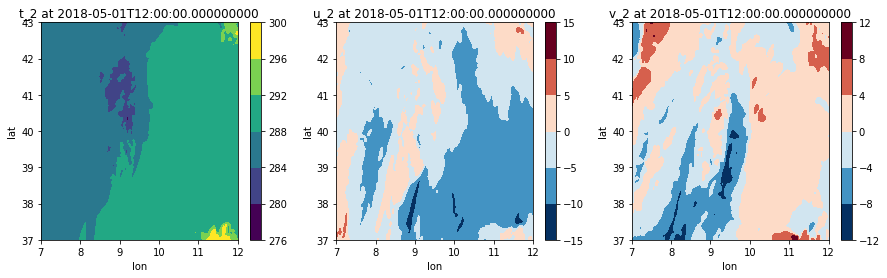

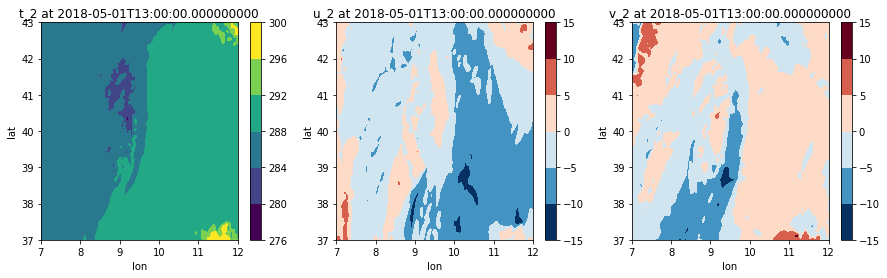

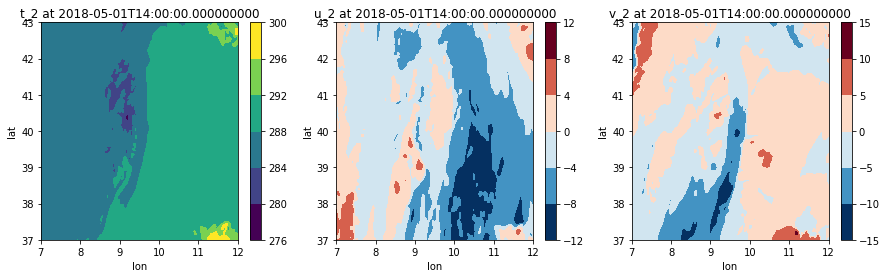

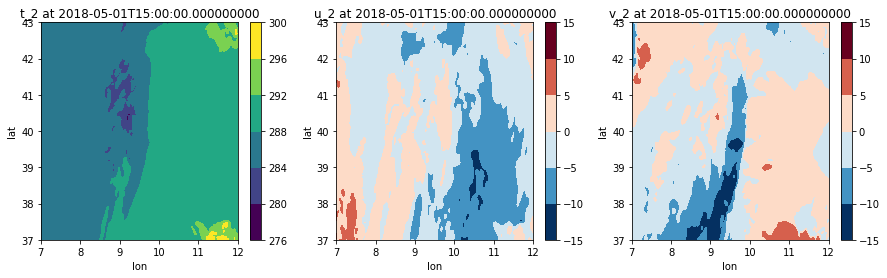

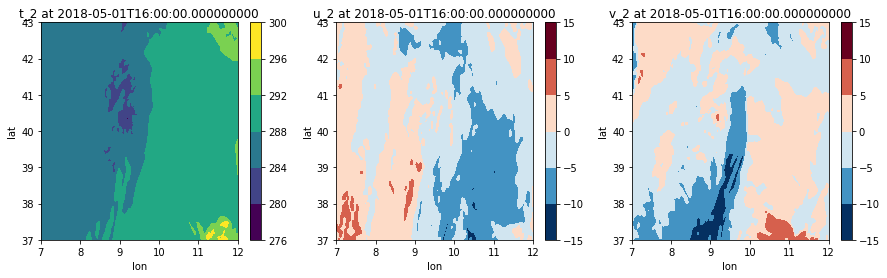

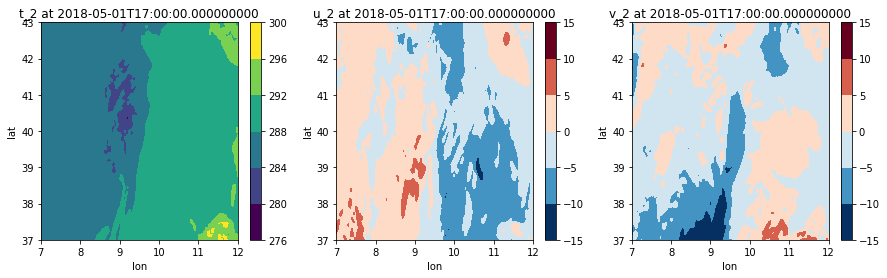

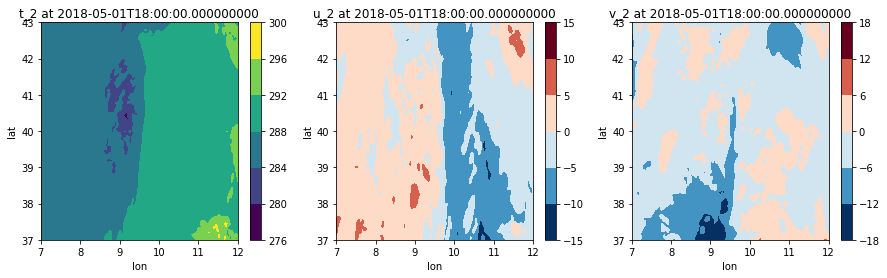

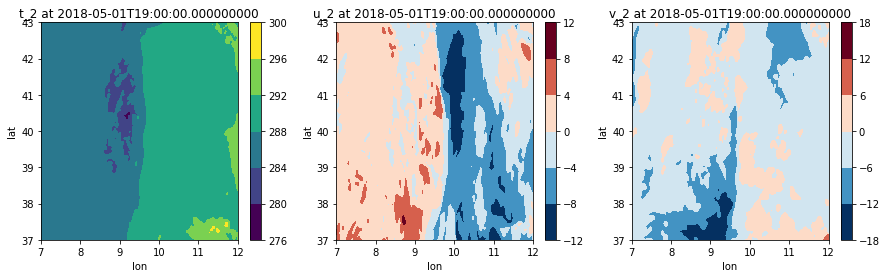

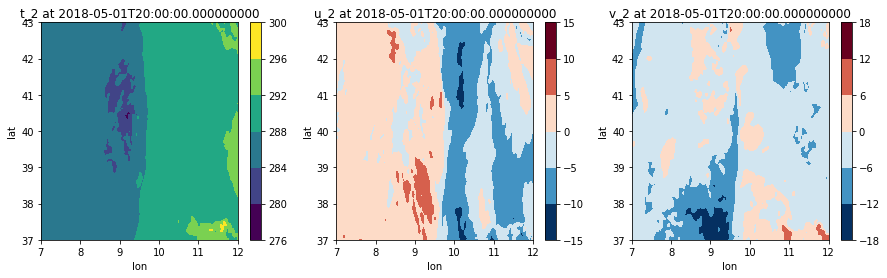

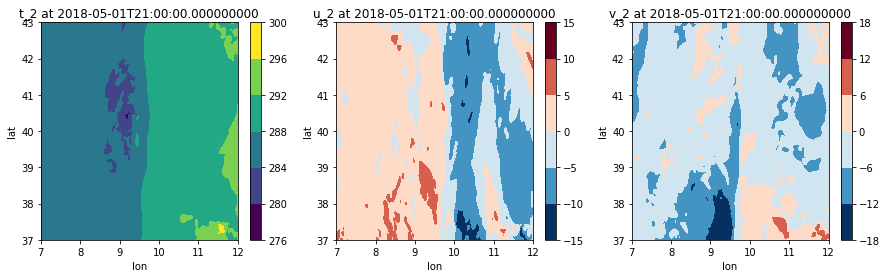

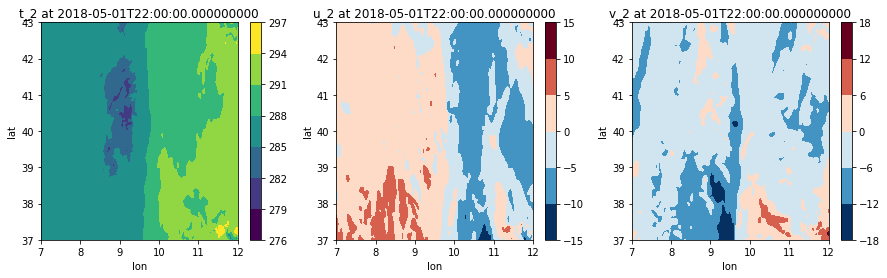

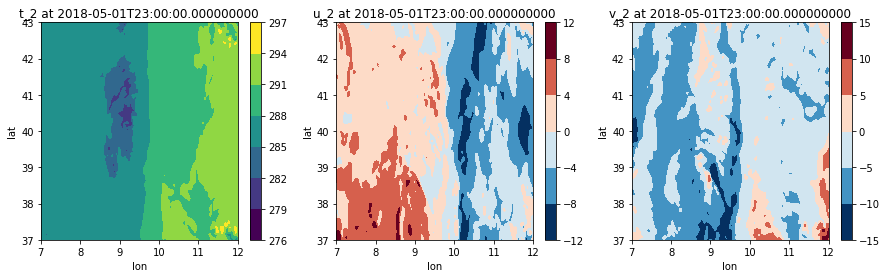

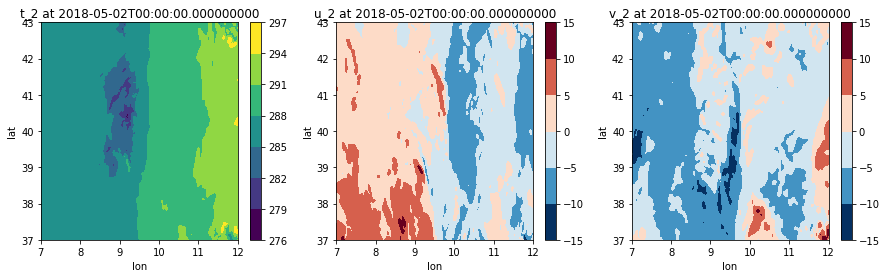

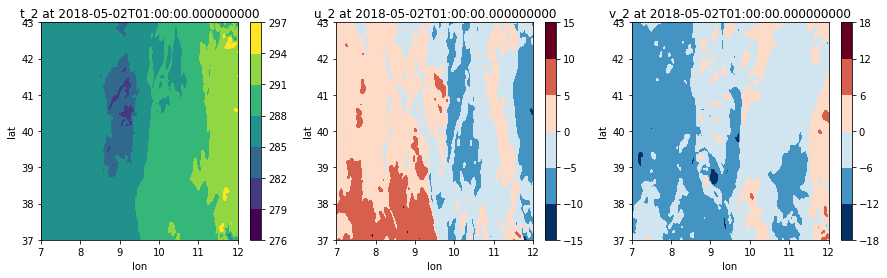

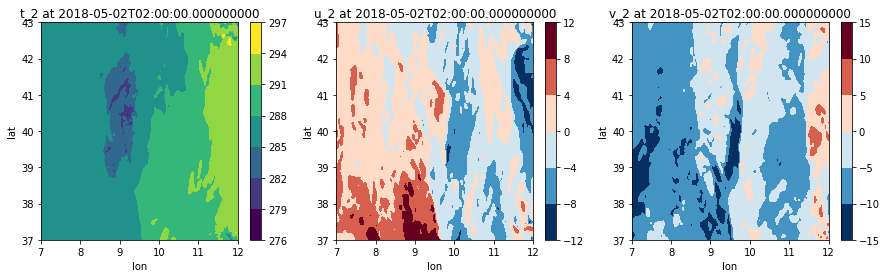

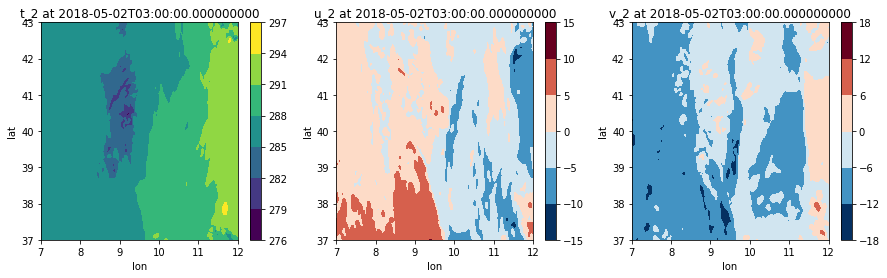

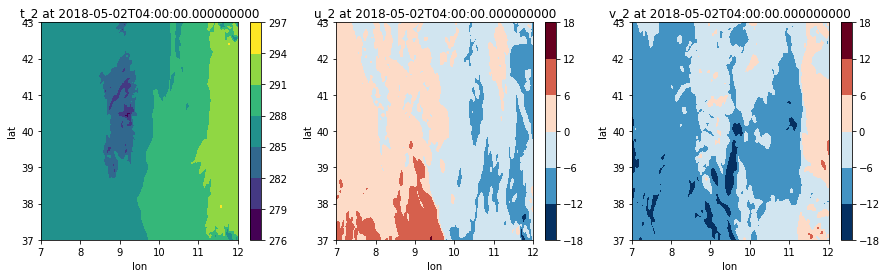

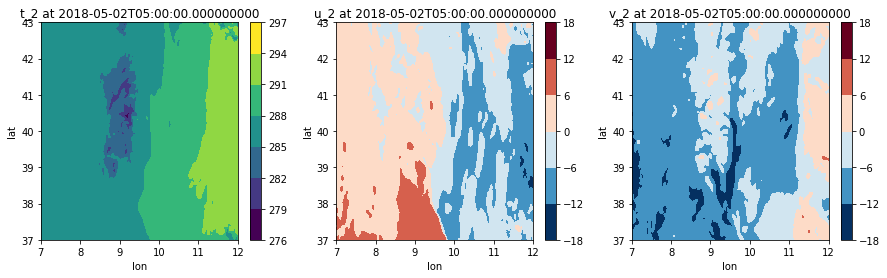

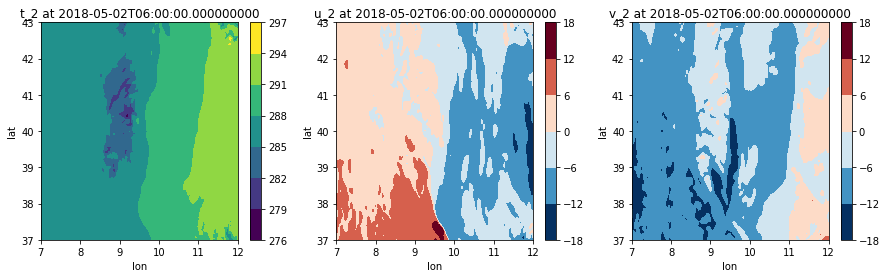

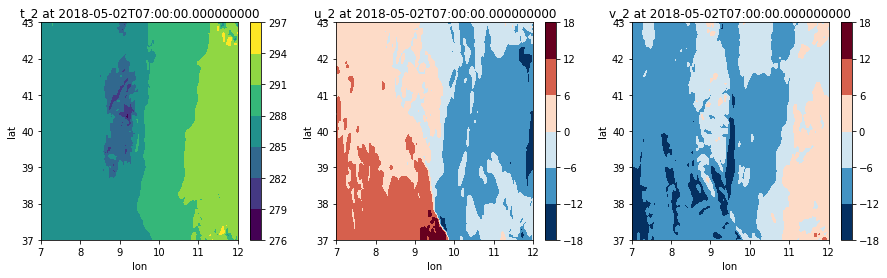

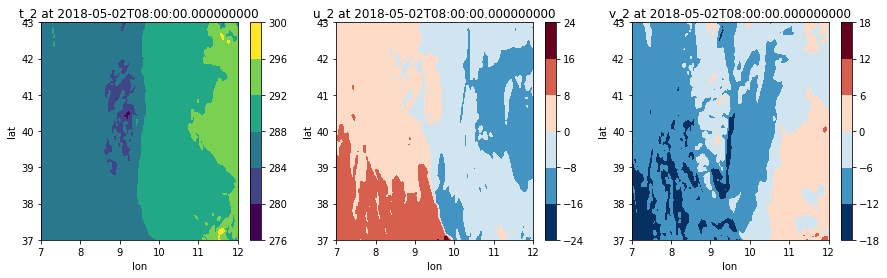

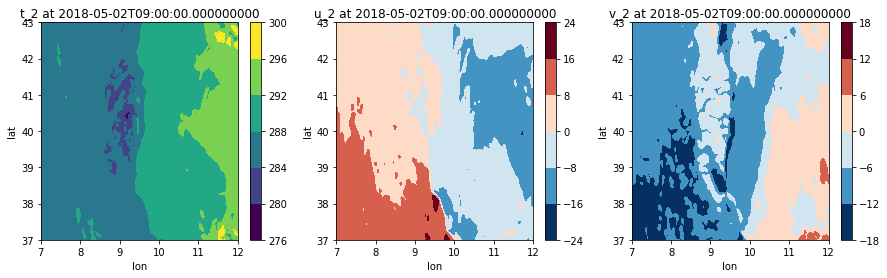

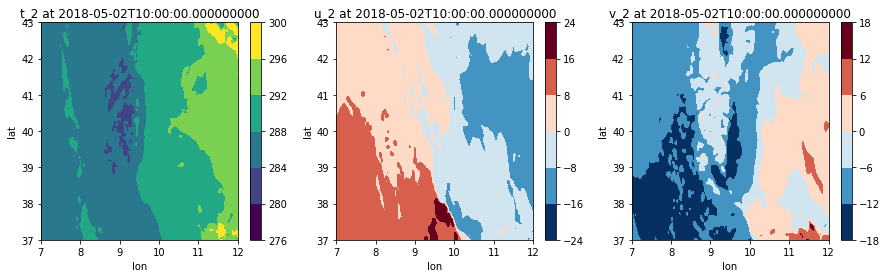

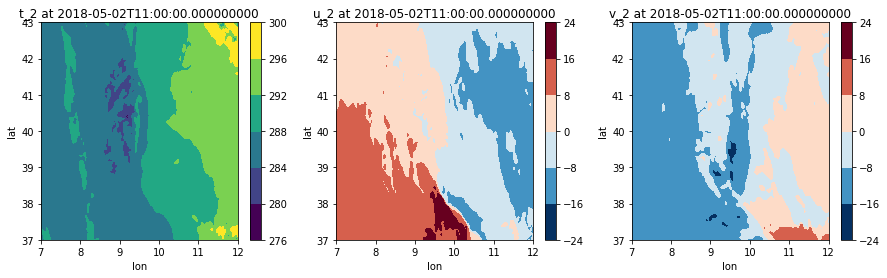

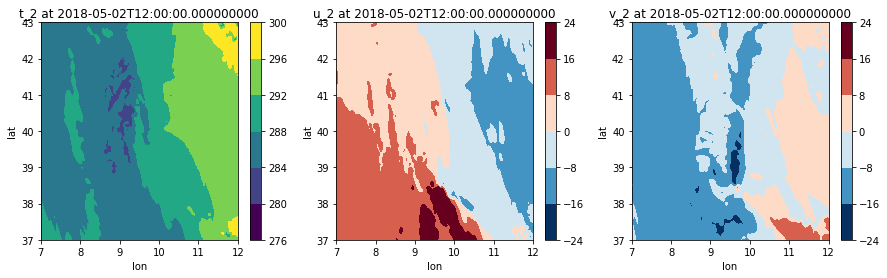

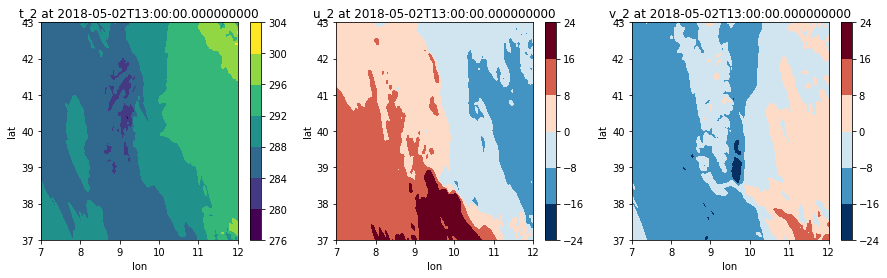

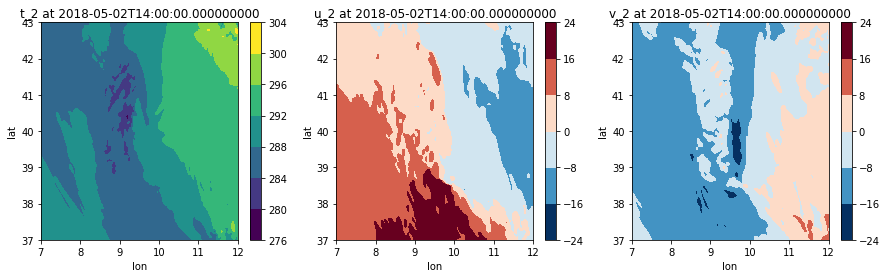

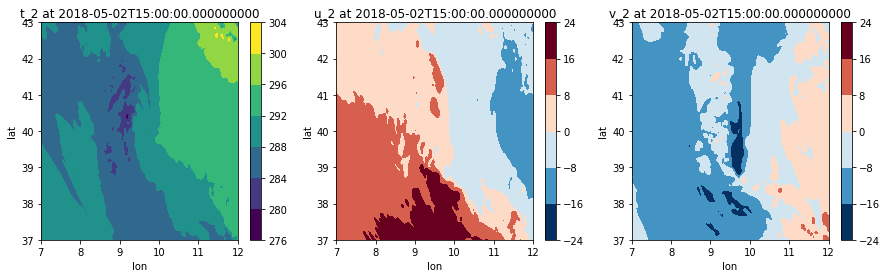

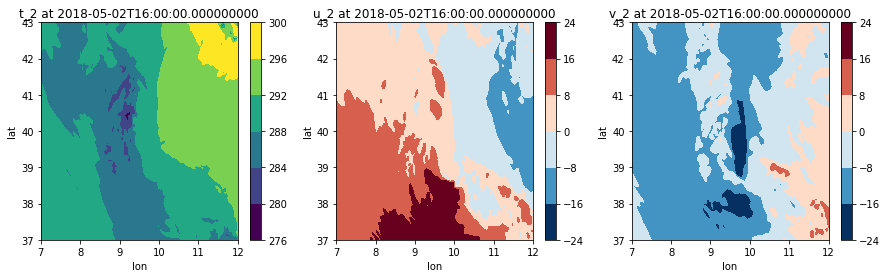

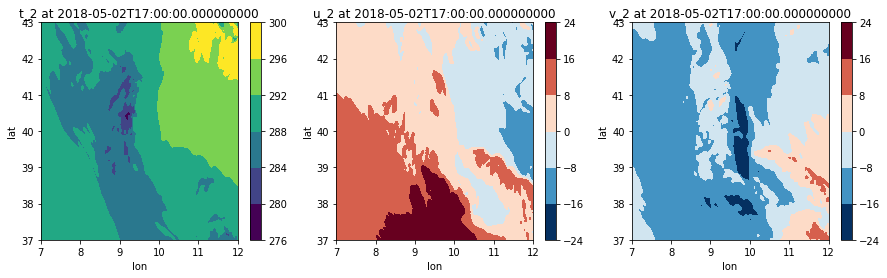

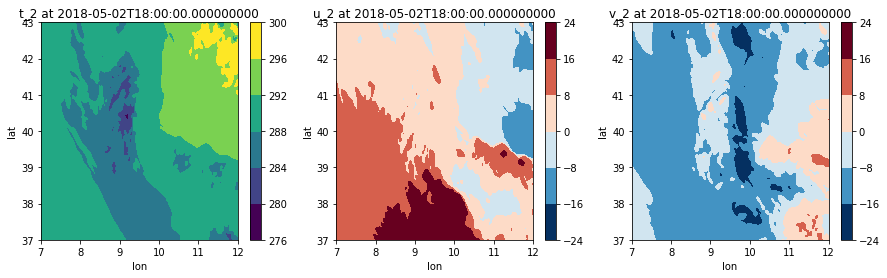

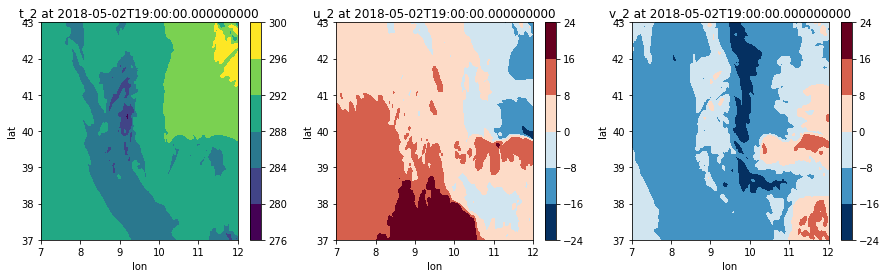

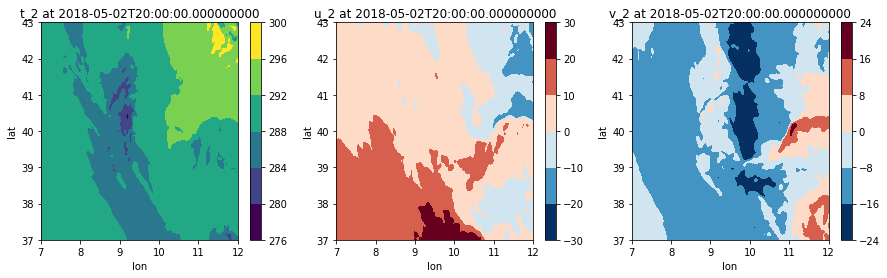

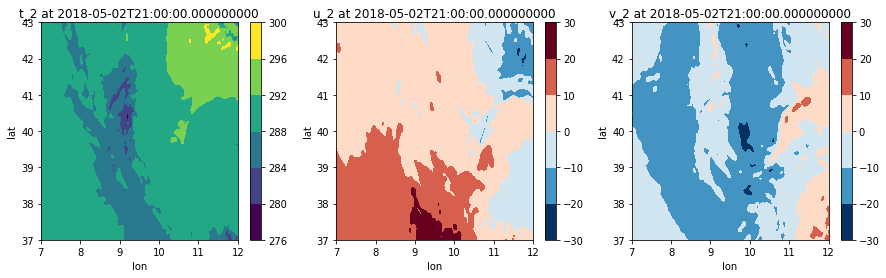

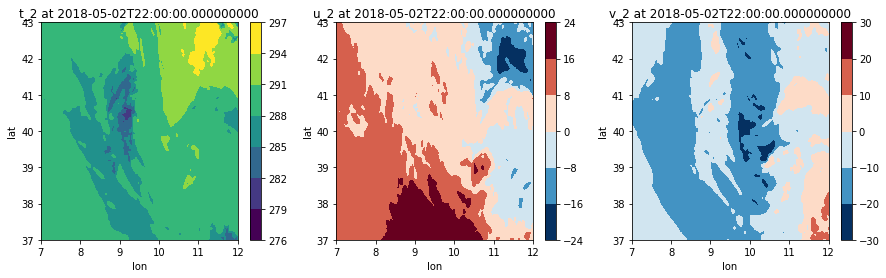

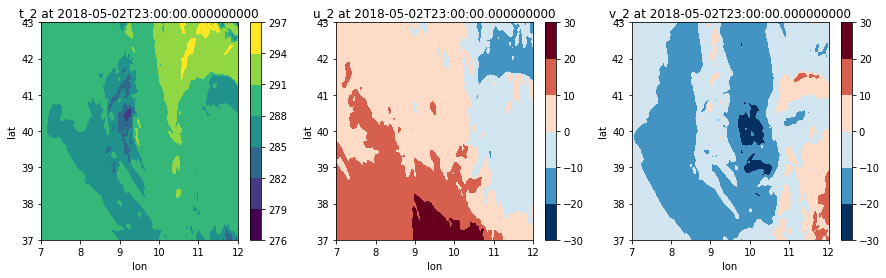

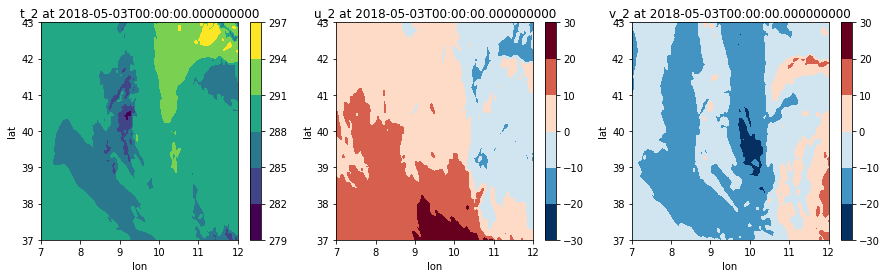

In [10]:
levs = d.coords['lev']
times = d.coords['time']

for t in times:
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
    for i, fname in enumerate(['t_2', 'u_2', 'v_2']):
        f = interp.interpolate(fname, {'time': t, 'lev': levs[0]})
        f.plot.contourf('lon', 'lat', ax=axes[i])
        axes[i].set_title("{} at {}".format(fname, t.values))
    plt.show()